# Landscape Analysis

## Load in Raw Data
Go through each record, load in supporting objects, flatten everything into records, and put into a massive dataframe.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
import recirq
import cirq
import numpy as np
import pandas as pd
from datetime import datetime
from recirq.qaoa.experiments.p1_landscape_tasks import \
    DEFAULT_BASE_DIR, DEFAULT_PROBLEM_GENERATION_BASE_DIR, DEFAULT_PRECOMPUTATION_BASE_DIR, \
    ReadoutCalibrationTask

records = []
ro_records = []
for record in recirq.iterload_records(dataset_id="2020-06-tutorial", base_dir=DEFAULT_BASE_DIR):
    record['timestamp'] = datetime.fromisoformat(record['timestamp'])
    dc_task = record['task']
    
    if isinstance(dc_task, ReadoutCalibrationTask):
        ro_records.append(record)
        continue
    
    pgen_task = dc_task.generation_task    
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    record['bitstrings'] = record['bitstrings'].bits
    recirq.flatten_dataclass_into_record(record, 'task')
    recirq.flatten_dataclass_into_record(record, 'generation_task')    
    records.append(record)
    
# Associate each data collection task with its nearest readout calibration
for record in sorted(records, key=lambda x: x['timestamp']):
    record['ro'] = min(ro_records, key=lambda x: abs((x['timestamp']-record['timestamp']).total_seconds()))
    
df_raw = pd.DataFrame(records)    
df_raw.head()

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,timestamp,bitstrings,qubits,final_qubits,execution_time,problem,problem_type,dataset_id,device_name,n_shots,gamma,beta,line_placement_strategy,generation_task.dataset_id,generation_task.device_name,instance_i,n_qubits,ro
0,2020-06-16 15:12:39.833223,"[[1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 1...","[(1, 2), (2, 2)]","[(1, 2), (2, 2)]",0.344097,"(0, 1)",HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.000000,-0.628319,None,2020-06-tutorial,ColdQuanta16,0,2,"{'timestamp': 2020-06-16 15:12:35.066300, 'tas..."
1,2020-06-16 15:12:43.898672,"[[1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0...","[(1, 2), (2, 2)]","[(1, 2), (2, 2)]",0.278875,"(0, 1)",HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.314159,-0.314159,None,2020-06-tutorial,ColdQuanta16,0,2,"{'timestamp': 2020-06-16 15:12:35.066300, 'tas..."
2,2020-06-16 15:12:36.823716,"[[0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1...","[(1, 2), (2, 2)]","[(1, 2), (2, 2)]",0.262205,"(0, 1)",HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.942478,-0.471239,None,2020-06-tutorial,ColdQuanta16,0,2,"{'timestamp': 2020-06-16 15:12:35.066300, 'tas..."
3,2020-06-16 15:12:40.881933,"[[1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [0, 0...","[(1, 2), (2, 2)]","[(1, 2), (2, 2)]",0.367471,"(0, 1)",HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.942478,0.628319,None,2020-06-tutorial,ColdQuanta16,0,2,"{'timestamp': 2020-06-16 15:12:35.066300, 'tas..."
4,2020-06-16 15:11:13.421265,"[[1, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 1...","[(1, 2), (2, 2)]","[(1, 2), (2, 2)]",0.291688,"(0, 1)",HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.314159,0.314159,None,2020-06-tutorial,ColdQuanta16,0,2,"{'timestamp': 2020-06-16 15:10:52.837803, 'tas..."


## Narrow down to Relevant Data
Drop unnecessary metadata and use bitstrings to compute the expected value of the energy. In general, it's better to save the raw data and lots of metadata so we can use it if it becomes necessary in the future.

In [3]:
from recirq.qaoa.simulation import hamiltonian_objectives

def compute_energies(row):
    permutation = []
    qubit_map = {}
    for i, q in enumerate(row['qubits']):
        fi = row['final_qubits'].index(q)
        permutation.append(fi)
        qubit_map[i] = q
        
    return hamiltonian_objectives(row['bitstrings'], 
                                  row['problem'], 
                                  permutation,
                                  row['ro']['calibration'],
                                  qubit_map)

# Start cleaning up the raw data
df = df_raw.copy()
df = df.drop(['line_placement_strategy', 
              'generation_task.dataset_id', 
              'generation_task.device_name'], axis=1)

# Compute energies
df['energies'] = df.apply(compute_energies, axis=1)
df = df.drop(['bitstrings', 'problem', 'ro', 'qubits', 'final_qubits'], axis=1)
df['energy'] = df.apply(lambda row: np.mean(row['energies']), axis=1)

# We won't do anything with raw energies right now
df = df.drop('energies', axis=1)

# Do timing somewhere else
df = df.drop([col for col in df.columns if col.endswith('_time')], axis=1)

df

,timestamp,problem_type,dataset_id,device_name,n_shots,gamma,beta,instance_i,n_qubits,energy
0,2020-06-16 15:12:39.833223,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.000000,-0.628319,0,2,-0.003262
1,2020-06-16 15:12:43.898672,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.314159,-0.314159,0,2,-0.525250
2,2020-06-16 15:12:36.823716,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.942478,-0.471239,0,2,-0.842638
3,2020-06-16 15:12:40.881933,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.942478,0.628319,0,2,0.525209
4,2020-06-16 15:11:13.421265,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.314159,0.314159,0,2,0.524281
...,...,...,...,...,...,...,...,...,...,...
116,2020-06-16 15:11:14.208113,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.785398,-0.471239,0,2,-0.887855
117,2020-06-16 15:14:09.452666,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.314159,-0.628319,0,2,-0.317375
118,2020-06-16 15:11:03.949717,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,1.413717,-0.157080,0,2,-0.166345
119,2020-06-16 15:14:05.779655,HardwareGridProblem,2020-06-tutorial,ColdQuanta16-simulator,50000,0.471239,-0.785398,0,2,-0.003986


## Compute theoretical landscape

Use a simulator to compute the noiseless landscape. This can get quite expensive, so it would be better practice to factor this out into Tasks in their own right: https://github.com/quantumlib/ReCirq/issues/21

In [5]:
def get_problem_graph(problem_type,
                    n=None,
                    instance_i=0):
    if n is None:
        if problem_type == 'HardwareGridProblem':
            n = 2
        elif problem_type == 'SKProblem':
            n = 3
        elif problem_type == 'ThreeRegularProblem':
            n = 4
        else:
            raise ValueError(repr(problem_type))
    
    r = df_raw[
        (df_raw['problem_type']==problem_type)&
        (df_raw['n_qubits']==n)&
        (df_raw['instance_i']==instance_i)
    ]['problem']
    return r.iloc[0]


from recirq.qaoa.simulation import exact_qaoa_values_on_grid, lowest_and_highest_energy
import itertools

def compute_exact_values(problem_type, x_grid_num=23, y_grid_num=21):
    exact = exact_qaoa_values_on_grid(
        graph=get_problem_graph(problem_type),
        num_processors=12,
        x_grid_num=x_grid_num,
        y_grid_num=y_grid_num,
    ).T.reshape(-1)
    
    exact_gammas = np.linspace(0, np.pi/2, x_grid_num)
    exact_betas  = np.linspace(-np.pi/4, np.pi/4, y_grid_num)
    exact_points = np.asarray(list(itertools.product(exact_gammas, exact_betas)))
    min_c, max_c = lowest_and_highest_energy(get_problem_graph(problem_type))
    return exact_points, exact, min_c, max_c

EXACT_VALS_CACHE = {k: compute_exact_values(k) 
                    for k in ['HardwareGridProblem']}#, 'SKProblem', 'ThreeRegularProblem']}

## Plot

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('ticks')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

# Note: I ran into https://github.com/matplotlib/matplotlib/issues/15410
# if I imported matplotlib before using multiprocessing in `exact_qaoa_values_on_grid`, YMMV.

In [7]:
import scipy.interpolate

def plot_landscape(problem_type, res=200, method='nearest', cmap='PuOr'):
    dfb = df
    dfb = dfb[dfb['problem_type'] == problem_type]
    xx, yy = np.meshgrid(np.linspace(0, np.pi/2, res), np.linspace(-np.pi/4, np.pi/4, res))
    exact_points, exact, min_c, max_c = EXACT_VALS_CACHE[problem_type]

    zz = scipy.interpolate.griddata(
        points=dfb[['gamma', 'beta']].values,
        values=dfb['energy'].values / min_c,
        xi=(xx, yy),
        method=method,
    )

    fig, (axl, axr) = plt.subplots(1, 2, figsize=(5*2, 5), sharey=True)
    norm = plt.Normalize(max_c/min_c, min_c/min_c)
    cmap = 'RdBu'
    extent=(0, 4, -2, 2)
    
    axl.imshow(zz, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='none')
    axl.set_xlabel(r'$\gamma\ /\ (\pi/8)$')
    axl.set_ylabel(r'$\beta\ /\ (\pi/8)$')
    axl.set_title('Experiment')
    
    zz_exact = scipy.interpolate.griddata(
        points=exact_points,
        values=(exact/min_c),
        xi=(xx, yy),
        method=method,
    )

    g = axr.imshow(zz_exact, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='none')
    axr.set_xlabel(r'$\gamma\ /\ (\pi/8)$')
    axr.set_title('Theory')

    fig.colorbar(g, ax=[axl, axr], shrink=0.8)

### Hardware Grid

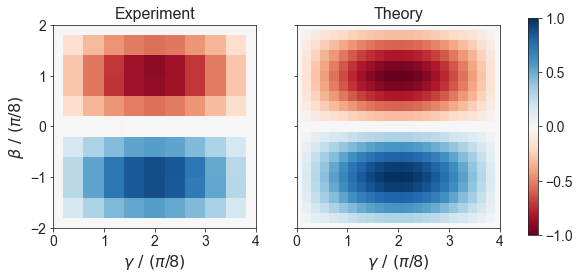

In [8]:
plot_landscape('HardwareGridProblem')

### SK Model

In [9]:
#plot_landscape('SKProblem')

## 3 Regular MaxCut

In [10]:
#plot_landscape('ThreeRegularProblem')